
Pyresias: a toy parton shower

LHAPDF 6.5.4 loading all 103 PDFs in set PDF4LHC15_nlo_mc_pdfas
PDF4LHC15_nlo_mc_pdfas, version 1; 103 PDF members
Evolving 10000 branches from Q= 1000.0 GeV --> Qc= 1.0 GeV


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5632.11it/s]


All evolutions ended
---
plotting evolution variable emission scales
saving the figure
---
output in plots/evolutionvar.pdf


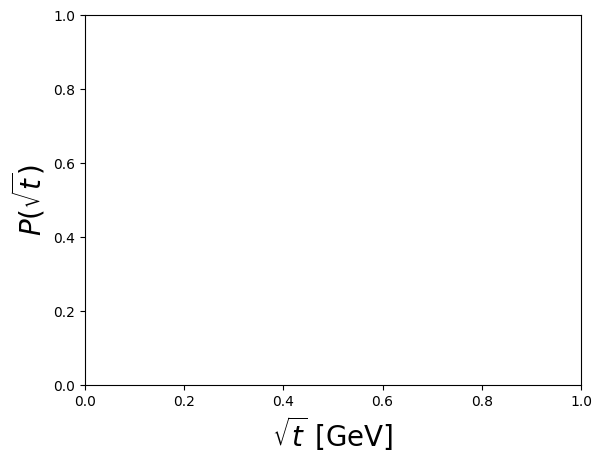

---
plotting pT of emissions
saving the figure
---
output in plots/transversemom.pdf


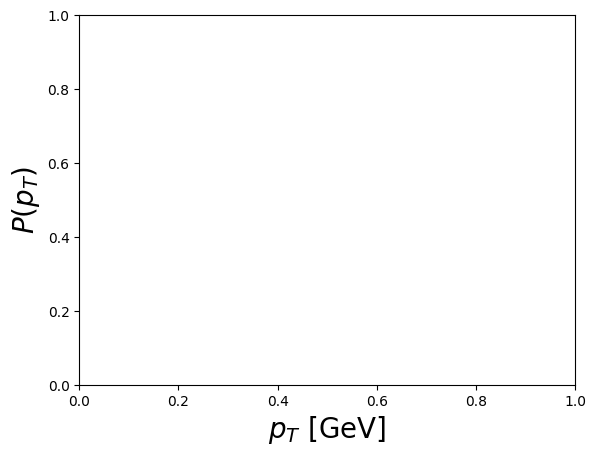

---
plotting z of emissions
saving the figure
---
output in plots/momentumfrac.pdf


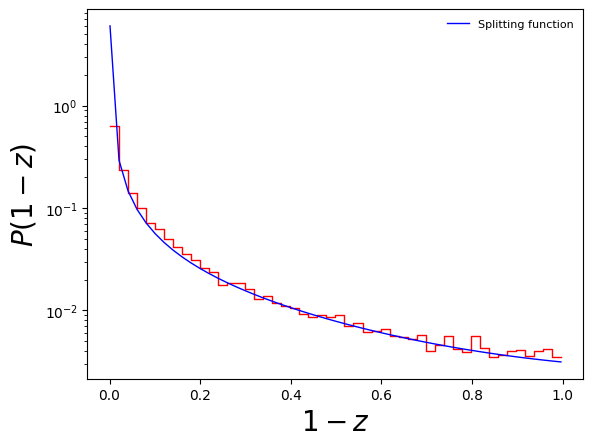

---
plotting virtual mass of emissions
saving the figure
---
output in plots/virtmass.pdf


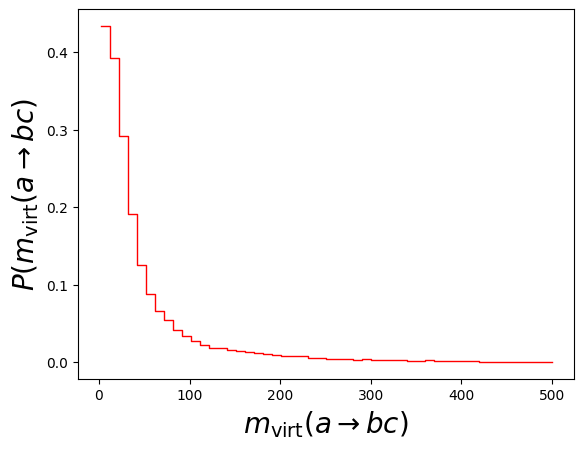


Done!


In [4]:
from random import * # random numbers
import os, subprocess # to check and create directories 
import math # python math
import numpy as np # numerical python
import scipy # scientific python
from scipy import optimize # for numerical solution of equations
from matplotlib import pyplot as plt # plotting
import matplotlib.gridspec as gridspec # more plotting 
from prettytable import PrettyTable # pretty printing of tables
from tqdm import tqdm # display progress
import lhapdf # LHAPDF python interface
from optparse import OptionParser # command line parameters
from scipy.integrate import quad # for numerical integrals

################################################
print('\nPyresias: a toy parton shower\n')
# a simple toy q -> q+g parton shower
#################################################

# function to print the emission information once they have been genrated:
def PrintEmissions(EmissionsArray):
    tbl = PrettyTable(["#", "Evo scale [GeV]", '1-z', 'pT [GeV]', 'virt. mass in a->bc [GeV]'])
    for i in range(len(EmissionsArray)):
        tbl.add_row([i, EmissionsArray[i][0], 1-EmissionsArray[i][1], EmissionsArray[i][2], EmissionsArray[i][3]])
    print(tbl)

#############
# SWITCHES: #
#############

# switch to print information or not:
debug = False
# switch to plot stuff or not:
plot = True

# output directory for plots
outputdirectory = 'plots/'

# RUN OPTIONS (defaults):

# the number of branches to evolve:
Nevolve = 10000
# the cutoff scale, e.g. 1 GeV. 
Qc = 1.
# the hard scale, e.g. 1000 GeV
Q = 1000.

##########################
# COMMAND LINE ARGUMENTS #
##########################

#parser = OptionParser(usage="%prog [options]")

#parser.add_option("-d", "--debug", dest="debug", default=False, action="store_true",
#                  help="Print debugging to screen")

#parser.add_option("-n", "--nevolve", dest="nevolve", default=Nevolve,
#                  help="Set the number of evolution branches")

#parser.add_option("-Q", dest="Q", default=Q,
#                  help="Set the starting scale for the evolution")

#parser.add_option("-c", dest="Qc", default=Qc,
#                  help="Set the cutoff scale for the evolution")

#parser.add_option("-o", dest="output", default=outputdirectory,
 #                 help="Set the output directory for plots")


# parse the command line arguments
#(options, args) = parser.parse_args()

# set command line arguments 
#debug = options.debug
#Nevolve = int(options.nevolve)
#Q = float(options.Q)
#Qc = float(options.Qc)
#outputdirectory = options.output + '/'

#################################################

# LHAPDF setup:
# set up the alphaS object from LHAPDF:
LHAPDF_alphaS = lhapdf.mkAlphaS("PDF4LHC15_nlo_mc_pdfas")

# set up the PDF to pick the minimum valid scale:
pdf = lhapdf.mkPDFs("PDF4LHC15_nlo_mc_pdfas")

#################################################

# Constants:
# QCD quark charge = (N^2 - 1)/2N for N colours
CF = 4./3.

# fixed scale if the alphaS is fixed:
scaleoption = "pt" # "pt" for the default scale, "fixed" for a fixed scale, given by fixedScale:
fixedScale = Q/2. # if the choice above is "fixed"

if scaleoption == "fixed":
    print('WARNING: alphaS is fixed during the evolution to scale=', Q/2)
    print('Set scaleoption = "pt" if you wish to capture some higher-order corrections')

#################################################

# the q -> q + g splitting function
def Pqq(z): return CF * (1. + z**2)/(1.-z)
    
# the q -> q + g splitting function *overestimate* 
def Pqq_over(z): return 2.*CF/(1.-z)

# the scale choice of alphaS 
def scale_of_alphaS(t, z):
    if scaleoption == "pt":
        return z * (1-z) * math.sqrt(t)
    elif scaleoption == "fixed":
        return fixedScale

# return the true alphaS using the PDF alphaS over 2 pi
def alphaS(t, z, Qc, aSover):
    scale = scale_of_alphaS(t, z)
    if scale < Qc:
        return aSover
    return LHAPDF_alphaS.alphasQ(scale)/2./math.pi

# the analytical integral of t * Gamma over z 
def tGamma(z, aSover):
    return -2.*aSover*CF*np.log1p(-z) 

# the inverse of the function t*Gamma, given the overestimate for alphaS:
def inversetGamma(r, aSover):
    return 1. - math.exp(- 0.5*r/CF/aSover)

# the overestimated upper and lower limit for the z integral:
def zp_over(t, Qc): return 1.-math.sqrt(Qc**2/t)
def zm_over(t, Qc): return math.sqrt(Qc**2/t)

# set the overestimate of alphaS once and for all
def get_alphaS_over(Q, Qc):
    if scaleoption == "pt":
        minscale = math.sqrt(pdf[0].q2Min) # the minimum scale^2 available to the PDF
        scale = minscale
    elif scaleoption == "fixed":
        scale = fixedScale
    alphaS_over = LHAPDF_alphaS.alphasQ(scale)/2./math.pi
    if debug: print('alpha_S overestimate set to', alphaS_over, 'for scale=', scale, 'GeV')
    return alphaS_over

# get the momentum fraction candidate for the emission
def Get_zEmission(t, Qc, R, aSover): return inversetGamma( tGamma(zm_over(t, Qc), aSover) + R * ( tGamma(zp_over(t, Qc), aSover) - tGamma(zm_over(t, Qc), aSover)), aSover)
    
# calculate the transverse momentum of the emission
def Get_pTsq(t, z): return z**2 * (1-z)**2 * t

# calculate the virtual mass-squared of the emitting particle
def Get_mvirtsq(t,z): return z*(1-z) * t

# the function E(ln(t/Q**2)) = ln(t/Q**2) - (1/r) ln(R) for the numerical solution for the evolution scale, given random number R
def EmissionScaleFunc(logt_over_Qsq, Q, Qc, R, aSover):
    # calculate t:
    t = Q**2 * math.exp( logt_over_Qsq )
    # get r:
    r = tGamma(zp_over(t, Qc), aSover) - tGamma(zm_over(t, Qc), aSover)
    # calculate E(ln(t/Q**2)), the equation to solve
    return logt_over_Qsq - (1./r) * math.log(R)

# a function that calculates (numerically) the emission scale given the initial scale Q, cutoff Qc and random number R
def Get_tEmission(Q, Qc, R, tfac, aSover):
    tolerance = 1E-3 # the tolerance for the solution
    popt = [Q, Qc, R, aSover] # options to pass to the function for the solver
    EmissionFunc_arg = lambda tEm : EmissionScaleFunc(tEm, *popt) # the function in a form appropriate for the solver
    # calculate the solution using "Ridder's" method
    sol, results = scipy.optimize.ridder(EmissionFunc_arg, math.log(tfac*Qc**2/Q**2), 0., xtol=tolerance, full_output=True, maxiter=1000)
    # get the actual evolution variable from the solution
    tEm_sol = Q**2 * math.exp( sol )
    # if a solution has not been found, terminate the evolution        
    if abs(EmissionFunc_arg(sol)) > tolerance:
            return Q**2, [], False
    # otherwise return the emission scale and continue
    return tEm_sol, results, True

# function that generates emissions:
def Generate_Emission(Q, Qc, tfac, aSover):
    generated = True
    # generate random numbers
    R1 = random()
    R2 = random()
    R3 = random()
    R4 = random()
    # solve for the (candidate) emission scale:
    tEm, results, continueEvolution = Get_tEmission(Q, Qc, R1, tfac, aSover)
    # if no solution is found then end branch
    if continueEvolution == False:
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution
    if debug: print('\tcandidate emission scale, sqrt(tEm)=', math.sqrt(tEm))
    # get the (candidate) z of the emission
    zEm = Get_zEmission(tEm, Qc, R2, aSover)
    if debug: print('\tcandidate momentum fraction, zEm=', zEm)
    # get the transverse momentum 
    pTsqEm = Get_pTsq(tEm, zEm)
    if debug: print('\tcandidate transverse momentum squared =', pTsqEm)
    # now check the conditions to accept or reject the emission:
    # check if the transverse momentum is physical:
    if pTsqEm < 0.:
        if debug: print('\t\temission rejected due to negative pT**2=', pTsqEm)
        generated = False
    # compare the splitting function overestimate prob to a random number
    if Pqq(zEm)/Pqq_over(zEm) < R3:
        if debug: print('\t\temission rejected due to splitting function overestimate, p=', Pqq(zEm)/Pqq_over(zEm), 'R=', R3)
        generated = False
    else:
        if debug: print('\t\temission NOT rejected due to splitting function overestimate, p=', Pqq(zEm)/Pqq_over(zEm), 'R=', R3)
    # compare the alphaS overestimate prob to a random number
    if alphaS(tEm, zEm, Qc, aSover)/aSover < R4:
        if debug: print('\t\temission rejected due to alphaS overestimate, p=', alphaS(tEm, zEm, Qc, aSover)/aSover, 'R=', R4)
        generated = False
    else:
        if debug: print('\t\temission NOT rejected due to alphaS overestimate, p=', alphaS(tEm, zEm, Qc, aSover)/aSover, 'R=', R4)
    # get the virtual mass squared:
    MsqEm = Get_mvirtsq(tEm, zEm)
    if generated == False: # rejected emission
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
    # return all the variables for the emission
    return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

# the function that performs the evolution of a single branch:
# returns a list of all the emissions for further processing
def Evolve(Q, Qmin, aSover):
    # the minimum evolution scale
    tEm_min = Qmin**2
    # counter for the number of emissions:
    Nem = 0
    # array to store emission info:
    Emissions = []
    fac_tEm = 3.5 # minimum value for the cutoff to try emissions = fac_tEm * Qc**2 (should be less than the actual cutoff)
    fac_cutoff = 4. # actual cutoff = fac_cutoff * Qc**2
    # star the evolution
    tEm = Q**2 # initial value of the evolution variable
    if debug: print('generating evolution for Q=', Q, 'GeV\n')
    # continue the evolution while we are above the cutoff:
    while tEm > fac_cutoff*tEm_min:
        # evolve:
        tEm, zEm, pTsqEm, MsqEm, generatedEmission, continueEvolution = Generate_Emission(math.sqrt(tEm), math.sqrt(tEm_min), fac_tEm, aSover)
        # if the solver could not find a solution, end the evolution
        if continueEvolution == False:
            if debug:
                print('no further emissions, evolution ended')
                print('total number of emissions=', Nem)
                print('\n')
                print('-----')
                print('Emissions table:')
                PrintEmissions(Emissions)
            return Emissions
        # if we have already passed the cutoff this emission does not count
        # this will also terminate the evolution
        if tEm < fac_cutoff*tEm_min: 
            if debug: print('\t\tXX->emission rejected at sqrt(t)=', math.sqrt(tEm), 'since it is below cutoff')
            zEm = 1.
            pTsqEm = 0.
            QsqEm = 0.
            if debug: print('total number of emissions=', Nem)
            return Emissions
        # if the emission was successful, append to the Emissions list and continue
        if zEm != 1.0:
            Emissions.append([math.sqrt(tEm), zEm, math.sqrt(pTsqEm), math.sqrt(MsqEm)])
            if debug: print('\t->successful emission at sqrt(t)=', math.sqrt(tEm), 'z=', zEm, 'pT=', math.sqrt(pTsqEm), 'mVirt=', math.sqrt(MsqEm))
            Nem = Nem + 1
    if debug:
        print('no further emissions, evolution ended')
        print('total number of emissions=', Nem)
        print('\n')
        print('-----')
        print('Emissions table:')
        PrintEmissions(Emissions)
    return Emissions

##########################
# Evolution begins here! #
##########################

# set the overestimate of alphaS once and for all:
alphaS_over = get_alphaS_over(Q, Qc)
if debug: print('alphaS overestimate=', alphaS_over)
    
# list to store all emission information:
AllEmissions = []

print('Evolving', Nevolve, 'branches from Q=', Q, 'GeV --> Qc=', Qc, 'GeV')

# perform evolution over Nevolve branches:
for j in tqdm(list(range(Nevolve))): # tqdm is the progress bar 
    # perform the evolution over a single branch j and return a list of all the emissions:
    Emissions = Evolve(Q,Qc,alphaS_over)
    # concatenate the emissions of this evolution branch to the list of all emissions to plot
    AllEmissions = AllEmissions + Emissions

print('All evolutions ended')

##############################
# Evolution has ended, plot! #
##############################

if plot == False:
    print('not plotting anything! exiting...')
    exit()

# create output directory if it does not exist:
if os.path.exists(outputdirectory) == False:
    mkdircommand = 'mkdir ' + outputdirectory
    p = subprocess.Popen(mkdircommand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, cwd='.')
    
# number of bins for histos
nbins=50

############
print('---')
print('plotting evolution variable emission scales')
# plot settings ########
plot_type = 'evolutionvar'
# plot:
# plot settings
ylab = '$P(\\sqrt{t})$'
xlab = '$\\sqrt{t}$ [GeV]'
ylog = False
xlog = False

# construct the axes for the plot
gs = gridspec.GridSpec(4, 4)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)

tarray = []
for i in range(len(AllEmissions)):
    tarray.append(AllEmissions[i][0])

# get the histogram bins:
bins, edges = np.histogram(tarray, bins=nbins)
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()

# normalise:
Y = Y/np.linalg.norm(Y)

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax.set_xlabel(xlab, fontsize=20)
# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# save the figure
print('saving the figure')
# save the figure in PDF format
infile = plot_type + '.dat'
print('---')
print('output in', outputdirectory + infile.replace('.dat','.pdf'))
#plt.savefig(outputdirectory + infile.replace('.dat','.pdf'), bbox_inches='tight')
#plt.close(fig)
plt.show()

###############
print('---')
print('plotting pT of emissions')
# plot settings ########
plot_type = 'transversemom'
# plot:
# plot settings
ylab = '$P(p_T)$'
xlab = '$p_T$ [GeV]'
ylog = False
xlog = False

# construct the axes for the plot
gs = gridspec.GridSpec(4, 4)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)

tarray = []
for i in range(len(AllEmissions)):
    tarray.append(AllEmissions[i][2])

# get the histogram bins:
bins, edges = np.histogram(tarray, bins=nbins)
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()

# normalise:
Y = Y/np.linalg.norm(Y)

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax.set_xlabel(xlab, fontsize=20)

# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# save the figure
print('saving the figure')
# save the figure in PDF format
infile = plot_type + '.dat'
print('---')
print('output in', outputdirectory + infile.replace('.dat','.pdf'))
#plt.savefig(outputdirectory + infile.replace('.dat','.pdf'), bbox_inches='tight')
#plt.close(fig)
plt.show()

###########################
print('---')
print('plotting z of emissions')
# plot settings ########
plot_type = 'momentumfrac'
# plot:
# plot settings
ylab = '$P(1-z)$'
xlab = '$1-z$'
ylog = True
xlog = False

# construct the axes for the plot
gs = gridspec.GridSpec(4, 4)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)

tarray = []
for i in range(len(AllEmissions)):
    tarray.append(1-np.array(AllEmissions[i][1]))

# get the histogram bins:
bins, edges = np.histogram(tarray, bins=nbins)
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()

# normalise:
Y = Y/np.linalg.norm(Y)

# plot:
plt.plot(X,Y, label='', color='red', lw=1)

# compare to the input splitting function
# this comparison is only correct if alphaS is fixed
# this is because the scale of alphaS is also a function of z 
Yspl = Pqq(1-X) * (left[1] - left[0])

# get the integral numerically, but not in the whole range
# since the splitting function diverges as z->1 and this cannot be captured numerically:
zp = X[-1]
zm = X[0]
def Pqq1mz(z):
    return Pqq(1-z)
YsplI = quad(Pqq1mz, 0.02, zp)
Yspl = Yspl/YsplI[0]
plt.plot(X,Yspl, color='blue', lw=1, label='Splitting function')

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax.set_xlabel(xlab, fontsize=20)

# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# create legend and plot/font size
ax.legend()
ax.legend(loc="upper right", numpoints=1, frameon=False, prop={'size':8})

# save the figure
print('saving the figure')
# save the figure in PDF format
infile = plot_type + '.dat'
print('---')
print('output in', outputdirectory + infile.replace('.dat','.pdf'))
#plt.savefig(outputdirectory + infile.replace('.dat','.pdf'), bbox_inches='tight')
#plt.close(fig)
plt.show()

###########################
print('---')
print('plotting virtual mass of emissions')
# plot settings ########
plot_type = 'virtmass'
# plot:
# plot settings
ylab = '$P(m_\\mathrm{virt}(a\\rightarrow bc)$'
xlab = '$m_\\mathrm{virt}(a\\rightarrow bc)$'
ylog = False
xlog = False

# construct the axes for the plot
gs = gridspec.GridSpec(4, 4)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(False)

tarray = []
for i in range(len(AllEmissions)):
    tarray.append(np.array(AllEmissions[i][3]))

# get the histogram bins:
bins, edges = np.histogram(tarray, bins=nbins)
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()

# normalise:
Y = Y/np.linalg.norm(Y)

# plot
plt.plot(X,Y, label='', color='red', lw=1)

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax.set_xlabel(xlab, fontsize=20)

# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# save the figure
print('saving the figure')
# save the figure in PDF format
infile = plot_type + '.dat'
print('---')
print('output in', outputdirectory + infile.replace('.dat','.pdf'))
#plt.savefig(outputdirectory + infile.replace('.dat','.pdf'), bbox_inches='tight')
#plt.close(fig)
plt.show()

print('\nDone!')
